# Fig3: Dissecting the structural basis of burst and sustained dynamics through domain swapping


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
import numpy as np
import arviz as az


In [2]:
df_A = pd.read_csv("~/Thomson Lab Dropbox/David Larios/activedrops/main/101324-k401-titration-rt/2p5TMB-1ulDNA_/output_data/merged_expression_PIV.csv")
df_C_E_G = pd.read_csv("~/Thomson Lab Dropbox/David Larios/activedrops/main/111624-C-E-G-RT/2p5ulTMB-0p5MT-1ulDNA_/output_data/merged_expression_PIV.csv")
df_H = pd.read_csv("~/Thomson Lab Dropbox/David Larios/activedrops/main/100624-kif3-titration-RT/2p5ulTMB-1ulDNAXnM_/output_data/merged_expression_PIV.csv")
df_H = df_H[df_H['condition'].str.contains('Kif3_') & df_H['condition'].str.contains('_1-RT')]

df_D = pd.read_csv("~/Thomson Lab Dropbox/David Larios/activedrops/main/110324-D_titration-RT/2p5TMB-1ulDNA_1/output_data/merged_expression_PIV.csv")

df_B_F = pd.read_csv("~/Thomson Lab Dropbox/David Larios/activedrops/main/111024-B-F-titrations-RT/2p5TMB-1ulDNA_/output_data/combined_expression.csv")

# Change the column names in df_B_F to be lowercase for 'Condition' and 'Subcondition'
df_B_F.rename(columns={'Condition': 'condition', 'Subcondition': 'subcondition'}, inplace=True)




# Merge the two DataFrames into one
df = pd.concat([df_A, df_C_E_G, df_H, df_D, df_B_F], ignore_index=True, join='outer')
df

,condition,subcondition,time (s),Time_min,Time_h,Mean Intensity,Protein Concentration_ng_ul,Protein Concentration_nM,Number of Protein Molecules,Rate of Change of Protein Molecules per Second,...,dcev [1]_mean,shear [1/s]_mean,strain [1/s]_mean,vector direction [degrees]_mean,correlation length [m]_mean,distance [m]_mean,power [W]_mean,work [J]_mean,time (min),time (h)
0,K401_0p625nM-RT,Rep1,0,0.0,0.000000,10.795248,1.376854,30.630794,3.675695e+10,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,K401_0p625nM-RT,Rep1,60,1.0,0.016667,10.763086,1.372752,30.539536,3.664744e+10,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,K401_0p625nM-RT,Rep1,120,2.0,0.033333,10.526032,1.342518,29.866912,3.584029e+10,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,K401_0p625nM-RT,Rep1,180,3.0,0.050000,10.755514,1.371786,30.518051,3.662166e+10,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,K401_0p625nM-RT,Rep1,240,4.0,0.066667,10.683785,1.362638,30.314526,3.637743e+10,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127256,F_160nM,Rep1,143400,2390.0,39.833333,754.824656,89.135592,1295.575472,1.554691e+12,-3.930279e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
127257,F_160nM,Rep1,143550,2392.5,39.875000,754.467194,89.093381,1294.961926,1.553954e+12,-2.760591e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
127258,F_160nM,Rep1,143700,2395.0,39.916667,754.205765,89.062509,1294.513212,1.553416e+12,-6.947325e+05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
127259,F_160nM,Rep1,143850,2397.5,39.958333,753.888627,89.025059,1293.968878,1.552763e+12,2.227608e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# Split condition column and extract components
df['protein'] = df['condition'].str.split('_').str[0]

# Replace protein names
df['protein'] = df['protein'].replace({'K401': 'A', 'Kif3': 'H'})

# Extract DNA concentration, removing -RT and handling different formats
df['DNA nM'] = df['condition'].str.split('_').str[1].str.replace('-RT', '').str.replace('p', '.').str.replace('nM', '')

df['kDa'] = df['protein'].apply(lambda x: 80 if x in ['A', 'B', 'C', 'D'] else 80 if x in ['E', 'F', 'G', 'H'] else None)

df['Protein Concentration_nM'] = df['Protein Concentration_nM'] * (27/(27+df['kDa']))

# Keep only those with Rep1 as subcondition
df = df[df['subcondition'] == 'Rep1']
df

,condition,subcondition,time (s),Time_min,Time_h,Mean Intensity,Protein Concentration_ng_ul,Protein Concentration_nM,Number of Protein Molecules,Rate of Change of Protein Molecules per Second,...,vector direction [degrees]_mean,correlation length [m]_mean,distance [m]_mean,power [W]_mean,work [J]_mean,time (min),time (h),protein,DNA nM,kDa
0,K401_0p625nM-RT,Rep1,0,0.0,0.000000,10.795248,1.376854,7.729266,3.675695e+10,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A,0.625,80.0
1,K401_0p625nM-RT,Rep1,60,1.0,0.016667,10.763086,1.372752,7.706238,3.664744e+10,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A,0.625,80.0
2,K401_0p625nM-RT,Rep1,120,2.0,0.033333,10.526032,1.342518,7.536510,3.584029e+10,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A,0.625,80.0
3,K401_0p625nM-RT,Rep1,180,3.0,0.050000,10.755514,1.371786,7.700817,3.662166e+10,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A,0.625,80.0
4,K401_0p625nM-RT,Rep1,240,4.0,0.066667,10.683785,1.362638,7.649460,3.637743e+10,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A,0.625,80.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127256,F_160nM,Rep1,143400,2390.0,39.833333,754.824656,89.135592,326.920913,1.554691e+12,-3.930279e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,160,80.0
127257,F_160nM,Rep1,143550,2392.5,39.875000,754.467194,89.093381,326.766094,1.553954e+12,-2.760591e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,160,80.0
127258,F_160nM,Rep1,143700,2395.0,39.916667,754.205765,89.062509,326.652867,1.553416e+12,-6.947325e+05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,160,80.0
127259,F_160nM,Rep1,143850,2397.5,39.958333,753.888627,89.025059,326.515511,1.552763e+12,2.227608e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,160,80.0


In [4]:
import matplotlib.pyplot as plt

# Get the default color cycle from the current style
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Create a dictionary mapping proteins to default colors
protein_color_map = {protein: color for protein, color in zip('ABCDEFGH', default_colors)}

print(protein_color_map)

{'A': '#1f77b4', 'B': '#ff7f0e', 'C': '#2ca02c', 'D': '#d62728', 'E': '#9467bd', 'F': '#8c564b', 'G': '#e377c2', 'H': '#7f7f7f'}


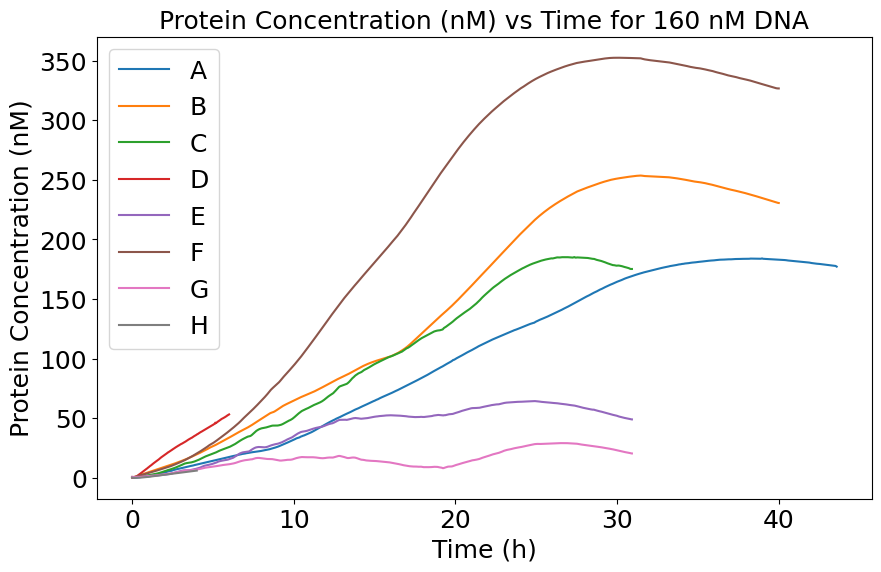

In [5]:
from scipy.ndimage import gaussian_filter1d

# Filter the DataFrame for 160 nM DNA concentration
df_filtered = df[df['DNA nM'] == '160']

# Plot protein concentration nM vs time for all proteins with specified colors
plt.figure(figsize=(10, 6))
proteins = sorted(df_filtered['protein'].unique())

for protein in proteins:
    df_protein = df_filtered[df_filtered['protein'] == protein]
    # Apply Gaussian filter with sigma=2
    smoothed_concentration = gaussian_filter1d(df_protein['Protein Concentration_nM'], sigma=2)
    plt.plot(df_protein['Time_h'], smoothed_concentration, label=protein, )

plt.xlabel('Time (h)', fontsize=18)
plt.ylabel('Protein Concentration (nM)', fontsize=18)
plt.title('Protein Concentration (nM) vs Time for 160 nM DNA', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)
plt.show()


In [6]:
df['DNA nM'].unique()[-4:0:-1]

array(['160', '80', '40', '20', '10', '5', '2.5', '1.25'], dtype=object)

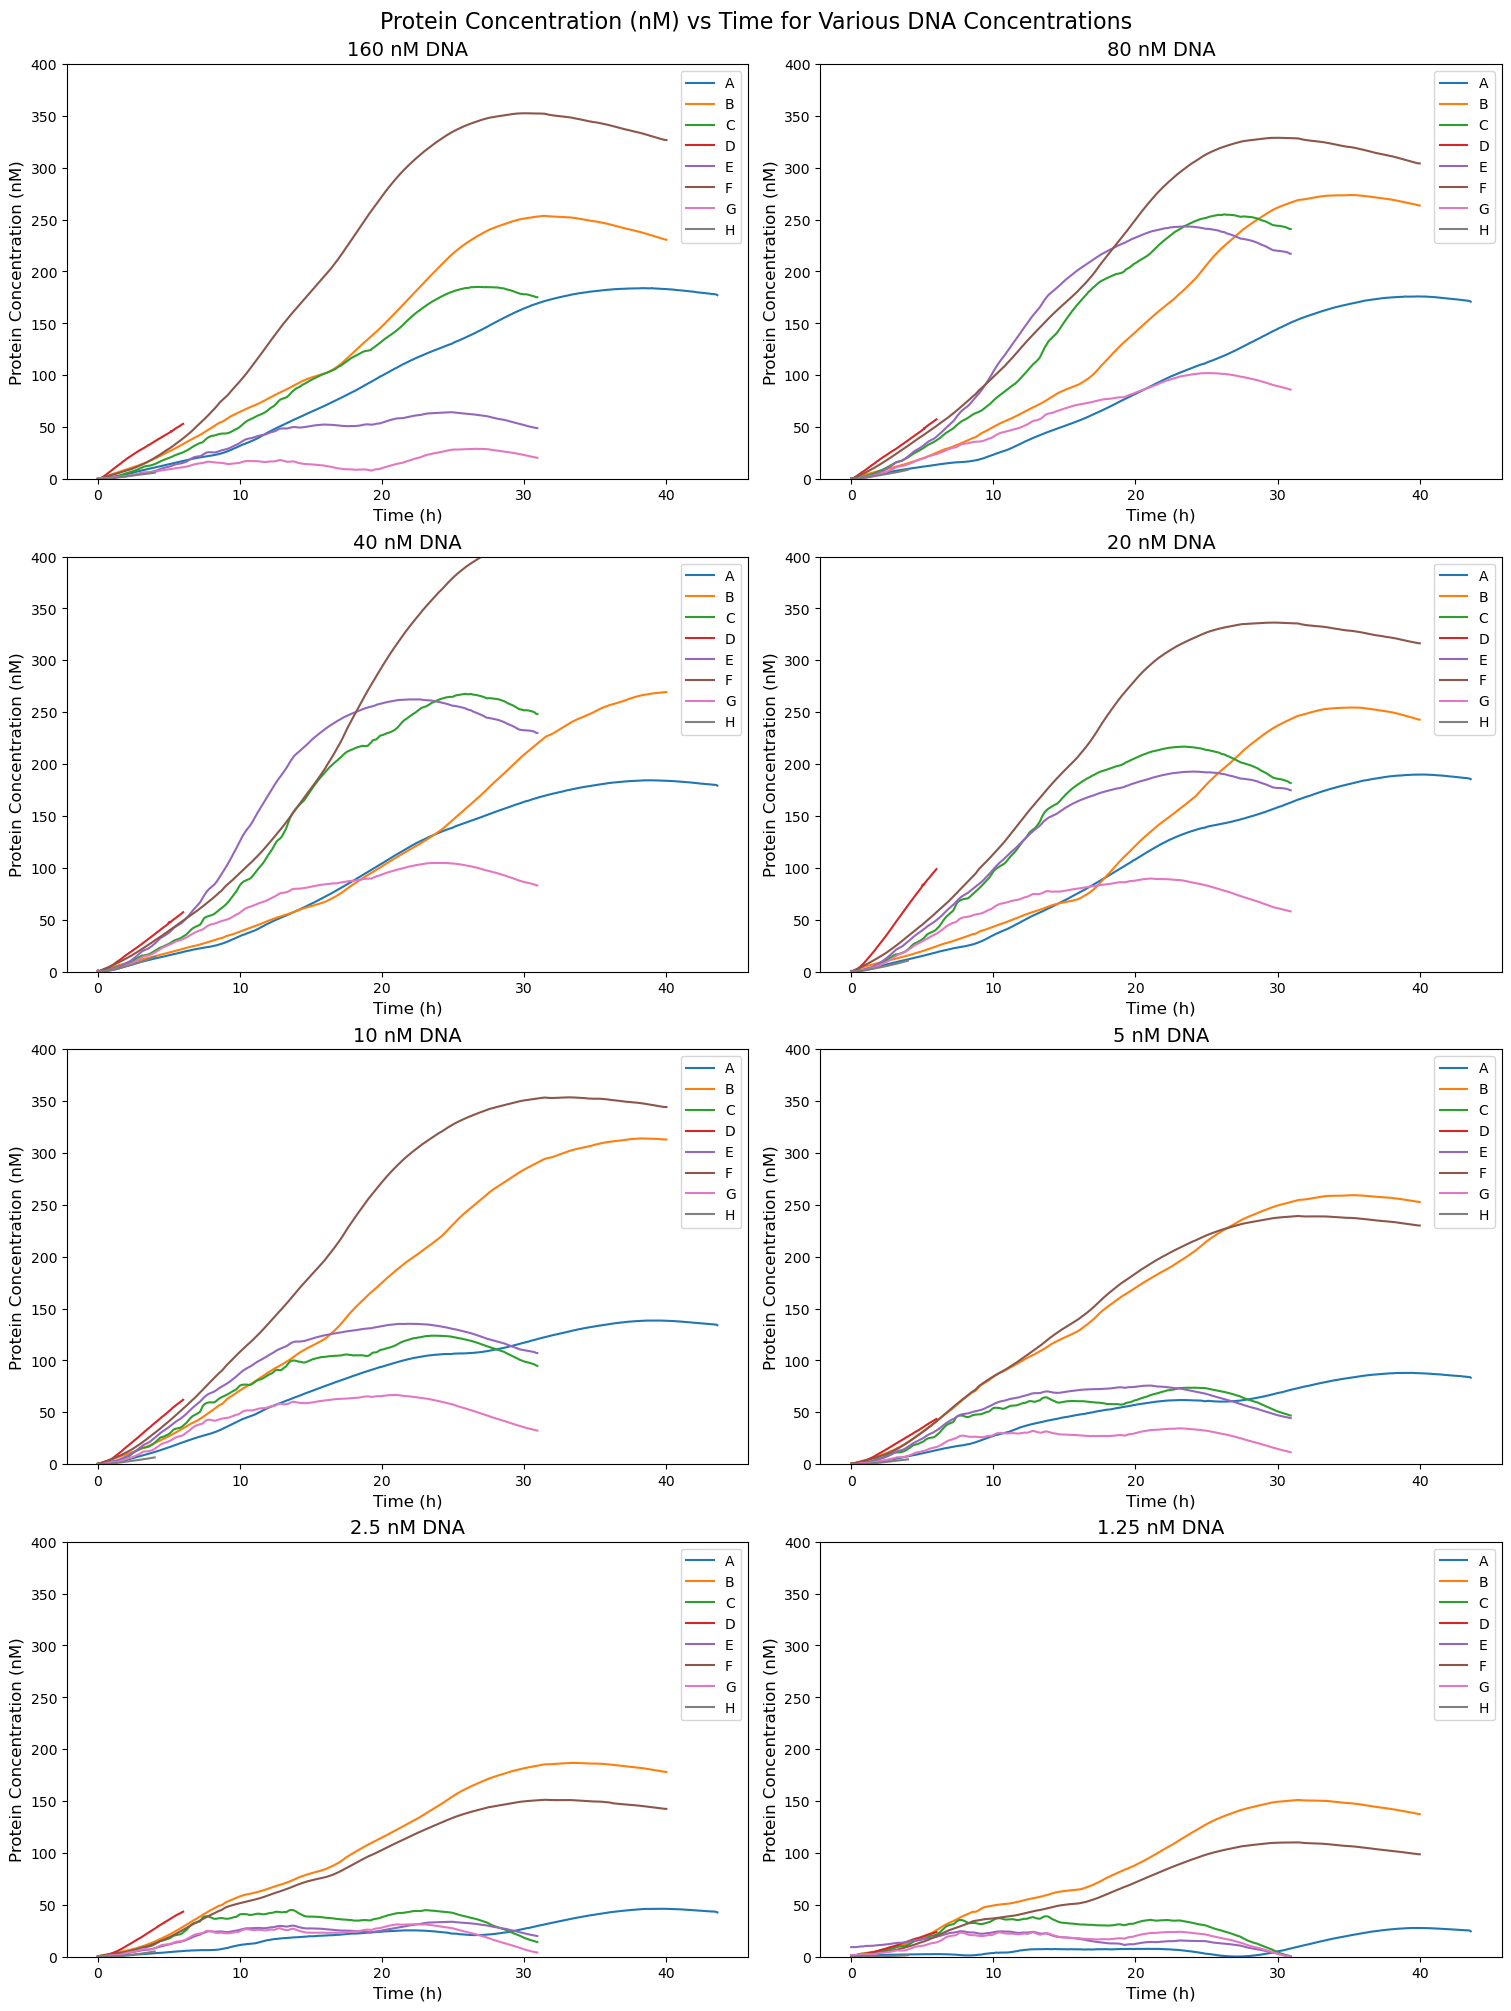

In [7]:
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt

# Unique DNA concentrations
dna_concentrations = df['DNA nM'].unique()[-4:0:-1]

# Determine the grid size
n_cols = 2
n_rows = (len(dna_concentrations) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows), constrained_layout=True)
axes = axes.flatten()

for i, dna_nM in enumerate(dna_concentrations):
    # Filter the DataFrame for each DNA concentration
    df_filtered = df[df['DNA nM'] == dna_nM]

    # Plot protein concentration nM vs time for all proteins with specified colors
    ax = axes[i]
    proteins = sorted(df_filtered['protein'].unique())

    for protein in proteins:
        df_protein = df_filtered[df_filtered['protein'] == protein]
        # Apply Gaussian filter with sigma=2
        smoothed_concentration = gaussian_filter1d(df_protein['Protein Concentration_nM'], sigma=2)
        ax.plot(df_protein['Time_h'], smoothed_concentration, label=protein)

    ax.set_xlabel('Time (h)', fontsize=12)
    ax.set_ylabel('Protein Concentration (nM)', fontsize=12)
    ax.set_title(f'{dna_nM} nM DNA', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.legend(fontsize=10)
    ax.set_ylim(0, 400)  # Set y-axis limits from 0 to 350

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('Protein Concentration (nM) vs Time for Various DNA Concentrations', fontsize=16)
plt.show()


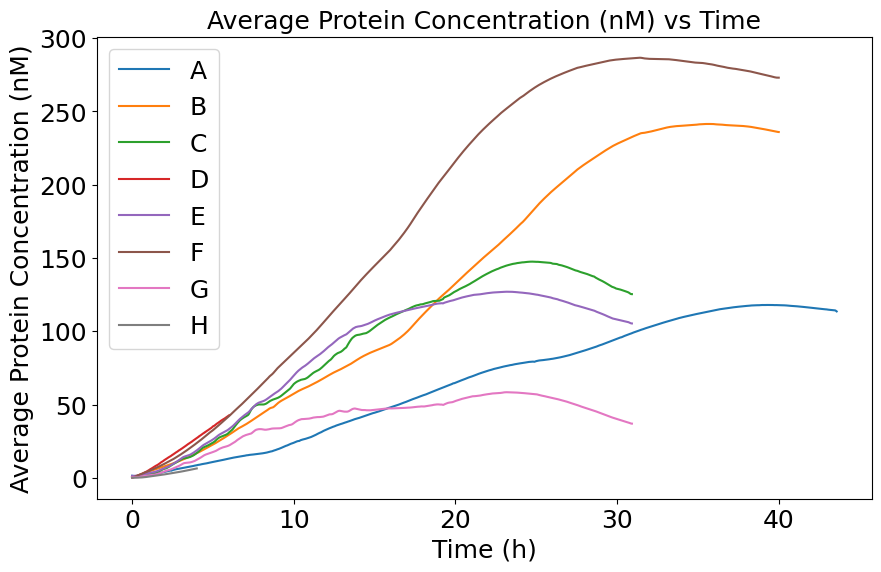

In [8]:
from scipy.ndimage import gaussian_filter1d

# Compute the average protein concentration across all DNA nM for each protein
df_avg = df.groupby(['protein', 'Time_h'])['Protein Concentration_nM'].mean().reset_index()

# Plot average protein concentration nM vs time for all proteins with specified colors
plt.figure(figsize=(10, 6))
proteins = sorted(df_avg['protein'].unique())[:-1]
color_map = {'A': '#1f77b4', 'B': '#ff7f0e', 'C': '#2ca02c', 'D': '#d62728', 'E': '#9467bd', 'F': '#8c564b', 'G': '#e377c2', 'H': '#7f7f7f'}

for protein in proteins:
    df_protein = df_avg[df_avg['protein'] == protein]
    color = color_map.get(protein, 'black')  # Default to black if protein not in color_map
    # Apply Gaussian filter with sigma=2
    smoothed_concentration = gaussian_filter1d(df_protein['Protein Concentration_nM'], sigma=2)
    plt.plot(df_protein['Time_h'], smoothed_concentration, label=protein, color=color)

plt.xlabel('Time (h)', fontsize=18)
plt.ylabel('Average Protein Concentration (nM)', fontsize=18)
plt.title('Average Protein Concentration (nM) vs Time', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)
plt.show()


In [9]:
df.columns


Index(['condition', 'subcondition', 'time (s)', 'Time_min', 'Time_h',
       'Mean Intensity', 'Protein Concentration_ng_ul',
       'Protein Concentration_nM', 'Number of Protein Molecules',
       'Rate of Change of Protein Molecules per Second',
       'Translation Rate aa_s', 'Unnamed: 0', 'frame', 'x [m]_mean',
       'y [m]_mean', 'u [m/s]_mean', 'v [m/s]_mean', 'data type [-]_mean',
       'vorticity [1/s]_mean', 'velocity magnitude [m/s]_mean',
       'divergence [1/s]_mean', 'dcev [1]_mean', 'shear [1/s]_mean',
       'strain [1/s]_mean', 'vector direction [degrees]_mean',
       'correlation length [m]_mean', 'distance [m]_mean', 'power [W]_mean',
       'work [J]_mean', 'time (min)', 'time (h)', 'protein', 'DNA nM', 'kDa'],
      dtype='object')

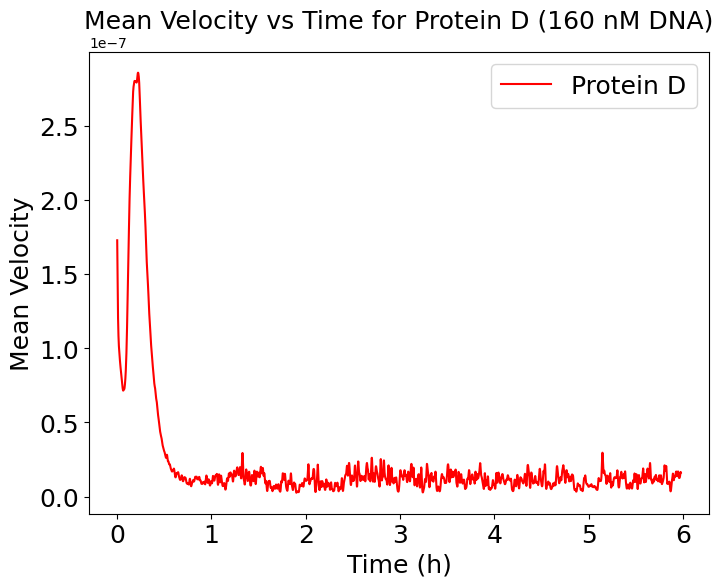

In [10]:
from scipy.ndimage import gaussian_filter1d

# Filter the DataFrame for 160 nM DNA concentration and protein D
df_filtered = df[(df['DNA nM'] == '160') & (df['protein'] == 'D')]

# Plot mean velocity vs time for protein D with specified color
plt.figure(figsize=(8, 6))
color = 'red'  # Color for protein D

# Apply Gaussian filter with sigma=2
smoothed_velocity = gaussian_filter1d(df_filtered['velocity magnitude [m/s]_mean'], sigma=2)
plt.plot(df_filtered['Time_h'], smoothed_velocity, label='Protein D', color=color)

plt.xlabel('Time (h)', fontsize=18)
plt.ylabel('Mean Velocity', fontsize=18)
plt.title('Mean Velocity vs Time for Protein D (160 nM DNA)', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)
plt.show()


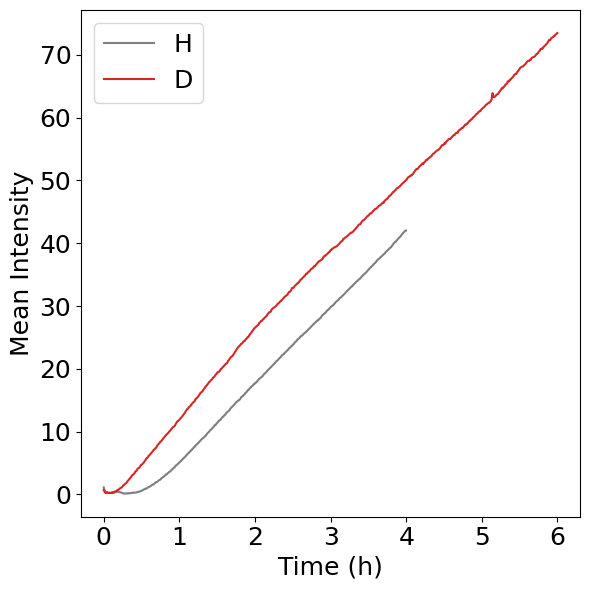

In [11]:
from scipy.ndimage import gaussian_filter1d

# Filter the DataFrame for 160 nM DNA concentration
df_filtered = df[df['DNA nM'] == '160']

# Plot mean intensity vs time for all proteins with specified colors
plt.figure(figsize=(6, 6))
proteins = ['H', 'D']
color_map = {'A': '#1f77b4', 'B': '#ff7f0e', 'C': '#2ca02c', 'D': '#d62728', 'E': '#9467bd', 'F': '#8c564b', 'G': '#e377c2', 'H': '#7f7f7f'}

for protein in proteins:
    df_protein = df_filtered[df_filtered['protein'] == protein]
    color = color_map.get(protein, 'black')  # Default to black if protein not in color_map
    # Apply Gaussian filter with sigma=2
    smoothed_intensity = gaussian_filter1d(df_protein['Mean Intensity'], sigma=2)
    plt.plot(df_protein['Time_h'], smoothed_intensity, label=protein, color=color)

plt.xlabel('Time (h)', fontsize=18)
plt.ylabel('Mean Intensity', fontsize=18)
# plt.title('Mean Intensity vs Time for 160 nM DNA', fontsize=18)
plt.xticks(fontsize=18)  # Set x ticks every 6 hours
plt.yticks(fontsize=18)
plt.legend(fontsize=18)
≈≈
# Adjust layout to prevent cutting off labels
plt.tight_layout()

# Save the plot as an SVG file
plt.savefig('../../../Downloads/mean_intensity_vs_time.svg', format='svg')

plt.show()


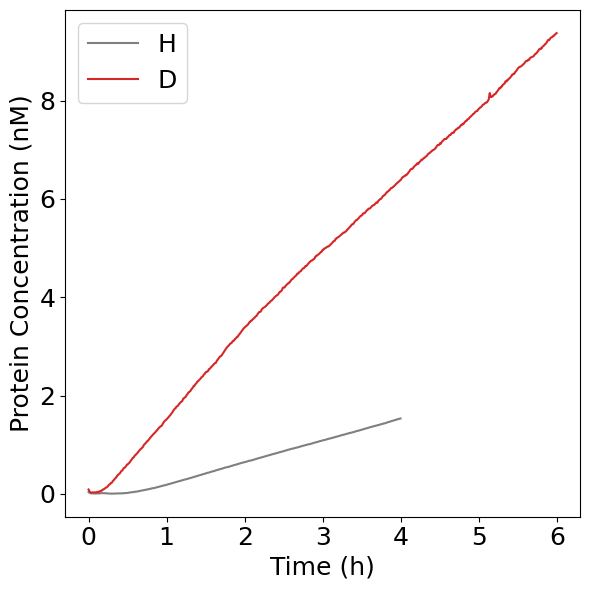

In [ ]:
from scipy.ndimage import gaussian_filter1d

# Filter the DataFrame for 160 nM DNA concentration
df_filtered = df[df['DNA nM'] == '160']

# Plot protein concentration nM vs time for all proteins with specified colors
plt.figure(figsize=(6, 6))
proteins = ['H', 'D']
color_map = {'A': '#1f77b4', 'B': '#ff7f0e', 'C': '#2ca02c', 'D': '#d62728', 'E': '#9467bd', 'F': '#8c564b', 'G': '#e377c2', 'H': '#7f7f7f'}

for protein in proteins:
    df_protein = df_filtered[df_filtered['protein'] == protein]
    color = color_map.get(protein, 'black')  # Default to black if protein not in color_map
    # Apply Gaussian filter with sigma=2
    smoothed_concentration = gaussian_filter1d(df_protein['Protein Concentration_nM'], sigma=2)
    plt.plot(df_protein['Time_h'], smoothed_concentration, label=protein, color=color)

plt.xlabel('Time (h)', fontsize=18)
plt.ylabel('Protein Concentration (nM)', fontsize=18)
# plt.title('Protein Concentration (nM) vs Time for 160 nM DNA', fontsize=18)
plt.xticks(fontsize=18)  # Set x ticks every 6 hours
plt.yticks(fontsize=18)
plt.legend(fontsize=18)

# Adjust layout to prevent cutting off labels
plt.tight_layout()


# Save the plot as an SVG file
plt.savefig('../../../Downloads/protein_concentration_vs_time.svg', format='svg')

plt.show()


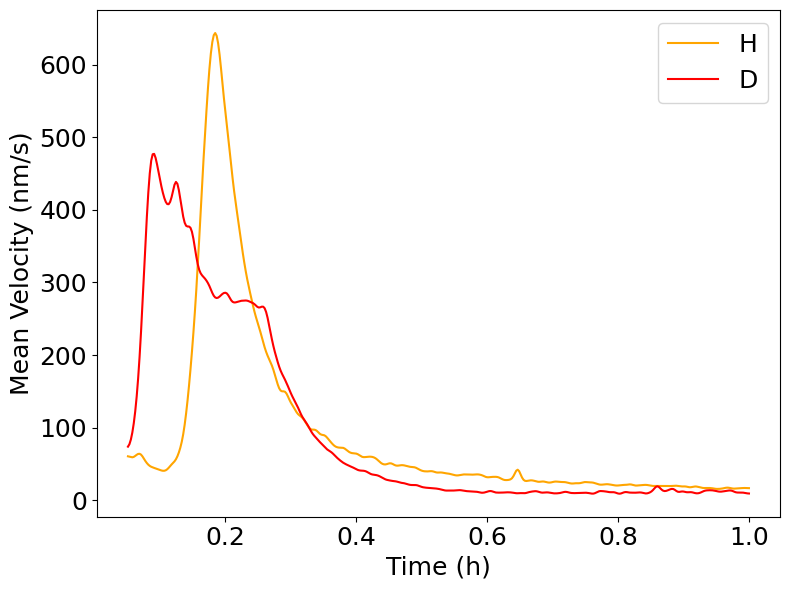

In [13]:
from scipy.ndimage import gaussian_filter1d

# Filter the DataFrame for 160 nM DNA concentration
df_filtered = df[df['DNA nM'] == '80']

# Plot mean velocity vs time for all proteins with specified colors
plt.figure(figsize=(8, 6))
proteins = ['H', 'D']
color_map = {'A': 'blue', 'C': 'green', 'D': 'red', 'E': 'pink', 'H': 'orange', 'G': 'purple'}

for protein in proteins:
    df_protein = df_filtered[df_filtered['protein'] == protein]
    # Drop NaN values for the plotted data
    df_protein = df_protein.dropna(subset=['velocity magnitude [m/s]_mean', 'Time_h'])
    # Filter data to start plotting from 2 hours on
    df_protein = df_protein[(df_protein['Time_min'] >= 3) & (df_protein['Time_min'] <= 60)]
    color = color_map.get(protein, 'black')  # Default to black if protein not in color_map
    # Apply Gaussian filter with sigma=2 and convert velocity to nm/s
    smoothed_velocity = gaussian_filter1d(df_protein['velocity magnitude [m/s]_mean'], sigma=2) * 1e9
    # Apply an additional Gaussian filter with sigma=5
    # smoothed_velocity = gaussian_filter1d(smoothed_velocity, sigma=5)
    # Adjust time to start from 0
    adjusted_time = df_protein['Time_h'] 
    plt.plot(adjusted_time, smoothed_velocity, label=protein, color=color)

plt.xlabel('Time (h)', fontsize=18)
plt.ylabel('Mean Velocity (nm/s)', fontsize=18)
# plt.title('Mean Velocity (nm/s) vs Time for 160 nM DNA', fontsize=18)
plt.xticks( fontsize=18)  # Set x ticks every 6 hours
plt.yticks(fontsize=18)
plt.legend(fontsize=18)

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# Save the plot as an SVG file
plt.savefig('../../../Downloads/mean_velocity_vs_time.svg', format='svg')

plt.show()


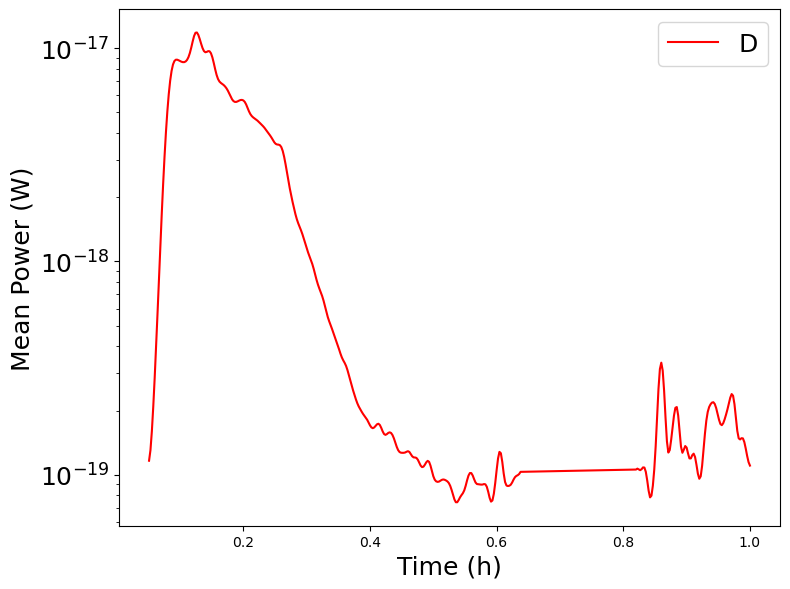

In [14]:
from scipy.ndimage import gaussian_filter1d

# Filter the DataFrame for 160 nM DNA concentration
df_filtered = df[df['DNA nM'] == '80']

# Plot mean power vs time for all proteins with specified colors
plt.figure(figsize=(8, 6))
proteins = ['D', ]
color_map = {'A': 'blue', 'C': 'green', 'D': 'red', 'E': 'pink', 'H': 'orange', 'G': 'purple'}

for protein in proteins:
    df_protein = df_filtered[df_filtered['protein'] == protein]
    # Drop NaN values for the plotted data
    df_protein = df_protein.dropna(subset=['power [W]_mean', 'Time_h'])
    # Filter data to start plotting from 2 hours on
    df_protein = df_protein[(df_protein['Time_min'] >= 3) & (df_protein['Time_min'] <= 60)]
    color = color_map.get(protein, 'black')  # Default to black if protein not in color_map
    # Apply Gaussian filter with sigma=2
    smoothed_power = gaussian_filter1d(df_protein['power [W]_mean'], sigma=2)
    # Apply an additional Gaussian filter with sigma=5
    # Adjust time to start from 0
    adjusted_time = df_protein['Time_h'] 
    plt.plot(adjusted_time, smoothed_power, label=protein, color=color)

plt.xlabel('Time (h)', fontsize=18)
plt.ylabel('Mean Power (W)', fontsize=18)
# plt.title('Mean Power (W) vs Time for 160 nM DNA', fontsize=18)
# plt.xticks(ticks=range(0, int(df_filtered['Time_h'].max()) - 1, 6), fontsize=18)  # Set x ticks every 6 hours
plt.yscale('log')  # Set y-axis to log scale
plt.yticks(fontsize=18)
plt.legend(fontsize=18)

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# Save the plot as an SVG file
plt.savefig('../../../Downloads/mean_power_vs_time.svg', format='svg')

plt.show()


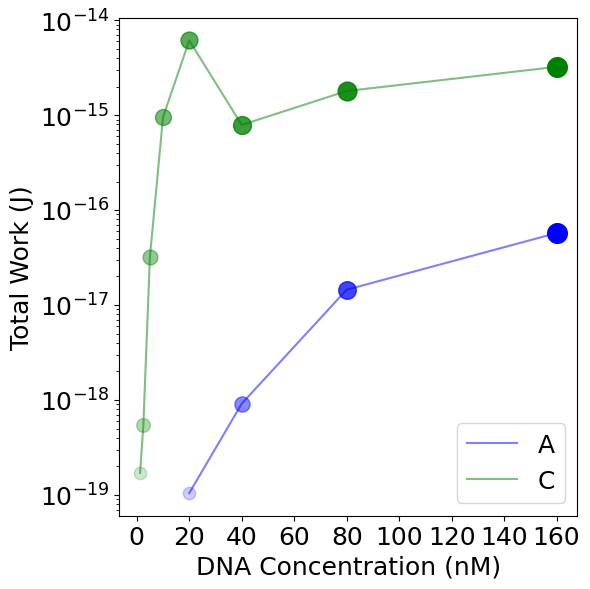

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Create figure
plt.figure(figsize=(6, 6))

# Define colors for each protein
color_map = {'A': 'blue', 'C': 'green', 'D': 'red', 'E': 'pink', 'H': 'orange', 'G': 'purple'}

# Manually select proteins to plot
selected_proteins = ['A', 'C',]  # Example: manually select proteins A, C, and G

# Process data for each selected protein
for protein in selected_proteins:
    if protein in df['protein'].unique():
        protein_data = df[df['protein'] == protein]
        
        # Calculate mean total work for each DNA concentration
        # Use last non-NaN value for each concentration
        dna_concs = []
        total_works = []
        
        # Get DNA concentrations in descending order
        for dna_conc in sorted(protein_data['DNA nM'].unique(), key=lambda x: float(x), reverse=True):
            data = protein_data[protein_data['DNA nM'] == dna_conc]
            work_data = data['work [J]_mean'].dropna()
            if len(work_data) > 0:
                dna_concs.append(float(dna_conc))  # Convert to float for plotting
                total_works.append(work_data.iloc[-1])
        
        # Plot points with decreasing transparency and size
        alphas = np.linspace(1.0, 0.2, len(dna_concs))
        sizes = np.linspace(200, 80, len(dna_concs))  # Adjust point sizes as needed
        for i, (x, y, alpha, size) in enumerate(zip(dna_concs, total_works, alphas, sizes)):
            plt.scatter(x, y, color=color_map.get(protein, 'black'), s=size, alpha=alpha)
        
        # Join points with lines
        plt.plot(dna_concs, total_works, color=color_map.get(protein, 'black'), alpha=0.5, label=protein)

plt.xlabel('DNA Concentration (nM)', fontsize=18)
plt.ylabel('Total Work (J)', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.grid(False)
plt.yscale('log')
plt.legend(loc='lower right', fontsize=18)

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# # Set spine thickness
# for spine in plt.gca().spines.values():
#     spine.set_linewidth(0.25)

plt.savefig('../../../Downloads/Selected_Proteins_Total_Work_vs_DNA_Concentration.svg', bbox_inches='tight')
plt.show()